## FAVORITA STORES SALE

## 1. Introduction
This project focuses on time series forecasting to predict store sales for Corporation Favorita, a large Ecuadorian-based grocery retailer. The objective is to build a model that accurately predicts the unit sales for thousands of items sold at different Favorita stores.


### 1.1. Objectives
Understand the data: The first objective is to gain insights into the store sales data, including store-specific information, product families, promotions, and sales numbers. This understanding will enable the company to make informed business decisions.

Predict store sales: Develop a reliable time series forecasting model that accurately predicts the unit sales for different product families at various Favorita stores. This will help the company optimize inventory management, plan promotions, and improve overall sales performance.

### 1.2. Methodology
To achieve the objectives, we will follow a structured approach:

Data Exploration: Thoroughly explore the provided datasets to understand the available features, their distributions, and relationships. This step will provide initial insights into the store sales data and help identify any data quality issues.

Data Preparation: Handle missing values, perform feature engineering, and encode categorical variables as necessary. This step may involve techniques like imputation, scaling, and one-hot encoding.

Time Series Analysis: Analyze the temporal aspects of the data, including trends, seasonality, and potential outliers. This analysis will provide a deeper understanding of the underlying patterns in store sales over time.

Model Selection and Training: Select appropriate time series forecasting models and train them using the prepared data. Consider incorporating external factors like promotions, holidays, and oil prices, if available, to enhance the forecasting accuracy.

Model Evaluation: Evaluate the trained models using appropriate metrics, such as mean absolute error (MAE), root mean squared error (RMSE), or mean absolute percentage error (MAPE). Assess the models' performance and identify the most accurate and reliable forecasting model.

Model Deployment and Forecasting: Deploy the chosen model to predict store sales for future time periods, leveraging the provided test dataset. Generate forecasts for the target period and assess the model's ability to capture the sales patterns accurately.

By following this framework, we are going to predict store sales of Corporation Favorita.

### HYPOTHESIS
Null Hypothesis: Promotions do not affect sales

Alternative hypothesis: Promotions increases sales

## Data Preparation

### Questions

The questions below are to be answered. Do note that, you are free to draw more hypothesis from the data.

1) Is the train dataset complete (has all the required dates)?

2) Which dates have the lowest and highest sales for each year?

3) Did the earthquake impact sales?

4) Are certain groups of stores selling more products? (Cluster, city, state, type)

5) Are sales affected by promotions, oil prices and holidays?

6) What analysis can we get from the date and its extractable features?

7) What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

In [190]:
# Import the necessary libraries

import pyodbc
from dotenv import dotenv_values

#Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Feature processing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, OrdinalEncoder
import warnings
warnings.filterwarnings('ignore')

#statistical analysis
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

#modelling 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pickle

In [191]:
# Load environment variables from .env file into a dictionary
db_variables = dotenv_values('.env')


# Get the values for the credentials you set in the '.env' file
server = db_variables.get("SERVER")
database = db_variables.get("DATABASE")
username = db_variables.get("USER")
password = db_variables.get("PASSWORD")

connection = f"DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [192]:
# Connect to the tables in the db

conn = pyodbc.connect(connection)

query = "SELECT * FROM dbo.oil"
query1 = "SELECT * FROM dbo.holidays_events"
query2 = "SELECT * FROM dbo.stores"

### 1st Dataset

In [193]:
# dbo.oil

oil = pd.read_sql(query,conn)
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [194]:
# dbo.holidays_events

holidays_events = pd.read_sql(query1,conn)
holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [195]:
# dbo.stores

stores = pd.read_sql(query2,conn)
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [196]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [197]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [198]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [199]:
# To change the date to the correct datatype

oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

### TEST dataset

In [200]:
# sample_submission

df_sample = pd.read_csv('sample_submission.csv')
df_sample.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [201]:
test = pd.read_csv('test.csv')
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [202]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [203]:
test.isna().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [204]:
test['date'].unique()

array(['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19',
       '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23',
       '2017-08-24', '2017-08-25', '2017-08-26', '2017-08-27',
       '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
      dtype=object)

### 3rd Dataset

In [205]:
df_trx = pd.read_csv("transactions.csv")
df_trx.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [206]:
df_train = pd.read_csv("E:\\AZUBI CAREER ACCELERATOR\\Data Analytics\\PROJECTS\\Project 3\\LP3 Regression Project\\store-sales-forecasting\\train.csv")
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [207]:
df_trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [208]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [209]:
# To change the date to correct datatype

df_trx['date'] = pd.to_datetime(df_trx['date'])
df_train['date'] = pd.to_datetime(df_train['date'])

# Data Understanding

## To check for missing data

In [210]:
oil.isna().sum()

date           0
dcoilwtico    43
dtype: int64

In [211]:
holidays_events.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [212]:
stores.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [213]:
df_trx.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [214]:
df_train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

#### Confirm the missing values handled

In [215]:
# oil.isna().sum()

### Merging the Datasets

In [216]:
# Merging the common columns ('store_nbr' and 'date') in the datasets using the inner merge() function
# Merge train_data with stores_df based on 'store_nbr' column
merged_df1 = pd.merge(df_train,stores, on='store_nbr', how='left')
#merged_df1.head(3)
# # Merge merged_df1 with trans_data based on 'date' and 'store_nbr' columns
merged_df2 = merged_df1.merge(df_trx, on=['date', 'store_nbr'], how='inner')
#merged_df2.head(3)
# # Merge merged_df2 with holidays_events_df based on 'date' column
merged_df3 = merged_df2.merge(holidays_events, on='date', how='inner')
#merged_df3.head(3)
# # Merge merged_df3 with oil_df based on 'date' column
data= merged_df3.merge(oil, on='date', how='inner')
data.head(3)
# # View the first five rows of the merged dataset


,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,NaN
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,NaN
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,NaN


We have used an inner merge to combine the datasets to ensures that we are working with a unified dataset that contains only the relevant information for the dates common to all datasets, facilitating a cleaner and more consistent analysis for time series forecasting.helps in avoiding having rows with missing values or mismatched timestamps in the final dataset.

Also an inner merge ensures that all the data points in the resulting dataset share the same timestamps, providing a unified time index for analysis and modeling.

In [217]:
# To check the shape

data.shape

(322047, 17)

In [218]:
# To check for missing values in the merged set
data.isna().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
type_x              0
cluster             0
transactions        0
type_y              0
locale              0
locale_name         0
description         0
transferred         0
dcoilwtico      22044
dtype: int64

- It is seen that we have  null values in the merged data.
- The merged dataset consists of 322047 rows and 17 columns observations.
- Two columns have been renamed as a result of the merging, type_x and type_y.

In [219]:
# Renaming the columns with the approapriate names
data = data.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
data.head(3)

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,NaN
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,NaN
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,NaN


In [220]:
# Generate summary statistics 
num_stats = ['sales','onpromotion','cluster','transactions','dcoilwtico']
data[num_stats].describe().T

,count,mean,std,min,25%,50%,75%,max
sales,322047.0,406.383452,1246.881240,0.000000,1.00,19.000000,241.260505,124717.000000
onpromotion,322047.0,3.727136,15.512095,0.000000,0.00,0.000000,1.000000,716.000000
cluster,322047.0,8.531202,4.713809,1.000000,4.00,9.000000,13.000000,17.000000
transactions,322047.0,1734.117840,1050.335018,54.000000,1030.00,1409.000000,2148.000000,8359.000000
dcoilwtico,300003.0,64.077912,25.147682,27.959999,44.66,51.439999,94.739998,107.949997


In [221]:
duplicates=data.duplicated().sum()
duplicates

0

In [222]:
categorical_columns = data.select_dtypes('object').columns
categorical_columns

Index(['family', 'city', 'state', 'store_type', 'holiday_type', 'locale',
       'locale_name', 'description'],
      dtype='object')

In [223]:
numerical_columns = data.select_dtypes('number').columns
numerical_columns

Index(['id', 'store_nbr', 'sales', 'onpromotion', 'cluster', 'transactions',
       'dcoilwtico'],
      dtype='object')

### Taking Care of Missing data

In [224]:
data.isna().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
store_type          0
cluster             0
transactions        0
holiday_type        0
locale              0
locale_name         0
description         0
transferred         0
dcoilwtico      22044
dtype: int64

In [225]:
# # Fill the missing Nan's on the categorical Columns
# # Handle the missing data in the categorical columns
#data[['holiday_type', 'locale', 'locale_name', 'description', 'transferred']] = data[['holiday_type', 'locale', 'locale_name', 'description', 'transferred']].fillna('None')

# Handle the missing data in the numerical columns
numerical_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
data['dcoilwtico'] = numerical_imputer.fit_transform(data[['dcoilwtico']])

In [226]:
data.isna().sum()

id              0
date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64

### Save data to CSV for later use in Visualization

In [227]:
data.to_csv('V_Data.csv', index=False)


# EDA

### Univariate analysis

<Figure size 400x400 with 0 Axes>

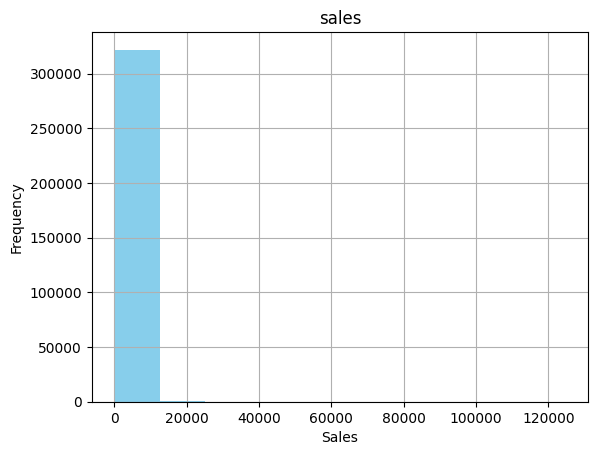

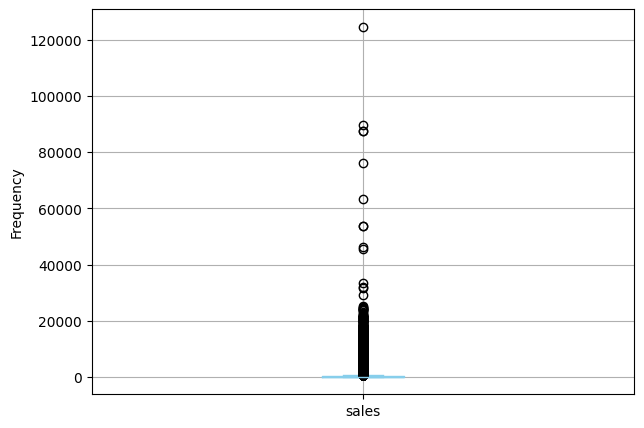

In [228]:
# To check for any outliers in the data

plt.figure(figsize=(4,4))
data.hist(column=['sales'],color='skyblue')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show();


# Box plot
plt.figure(figsize=(7,5))
data.boxplot(column='sales',color='skyblue')
plt.ylabel('Frequency')
plt.show()

* From the graphs above it shows that the sales data does not have any skiewness and that its has outliers

<Figure size 400x400 with 0 Axes>

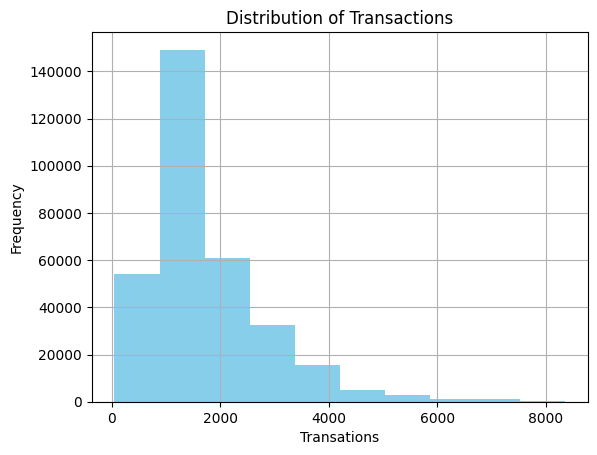

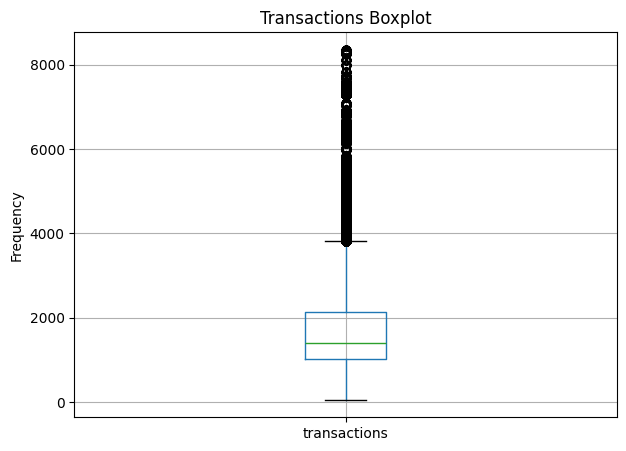

In [229]:
# Transaction data

plt.figure(figsize=(4,4))
data.hist(column=['transactions'],color='skyblue')
plt.xlabel('Transations')
plt.ylabel('Frequency')
plt.title('Distribution of Transactions')
plt.show();


# Box plot
plt.figure(figsize=(7,5))
data.boxplot(column='transactions')
plt.ylabel('Frequency')
plt.title('Transactions Boxplot')
plt.show()

The histogram provides insights into the distribution of transactions in the dataset. The shape of the histogram indicates that the majority of transactions fall into a specific range, which is evident from the high frequency observed on the left side of the histogram. As the transactions increase, the frequency gradually decreases, forming a right-skewed distribution. This suggests that there are relatively fewer instances of high transaction volumes. Overall, the histogram highlights the presence of a cluster of transactions with a lower frequency, indicating a pattern in the data.

<Figure size 400x400 with 0 Axes>

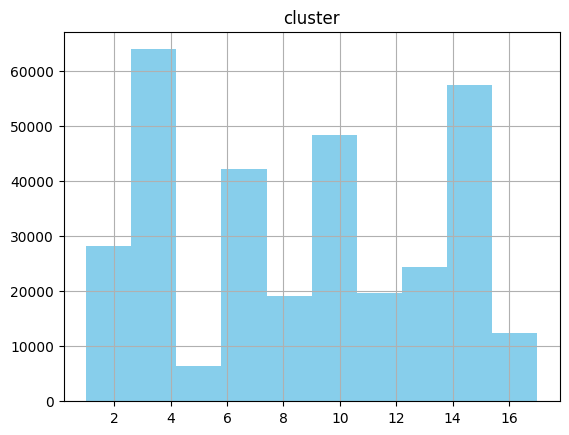

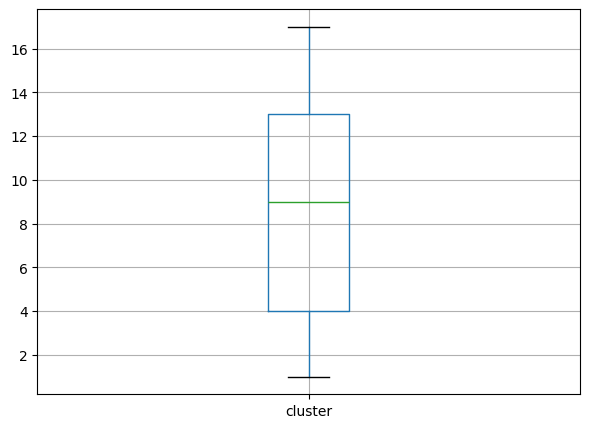

In [230]:
plt.figure(figsize=(4,4))
data.hist(column=['cluster'],color='skyblue')
plt.show();


# Box plot
plt.figure(figsize=(7,5))
data.boxplot(column='cluster')
plt.show()

<Figure size 400x400 with 0 Axes>

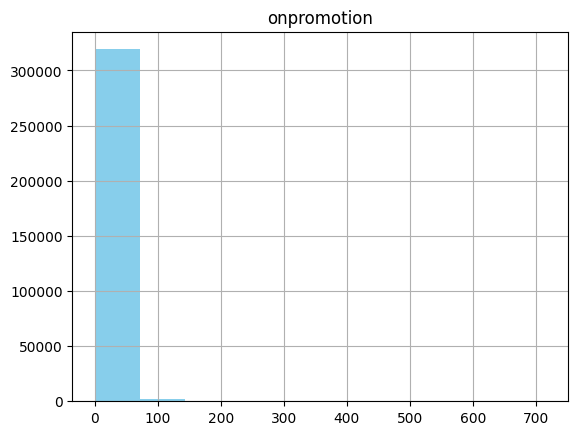

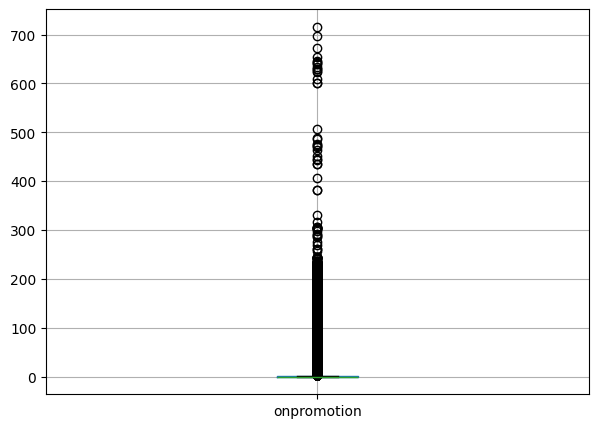

In [231]:
plt.figure(figsize=(4,4))
data.hist(column=['onpromotion'],color='skyblue')
plt.show();


# Box plot
plt.figure(figsize=(7,5))
data.boxplot(column='onpromotion')
plt.show()

* The onpromotion data indicates no skeweness but the boxplot shows that it has outliers

<Figure size 400x400 with 0 Axes>

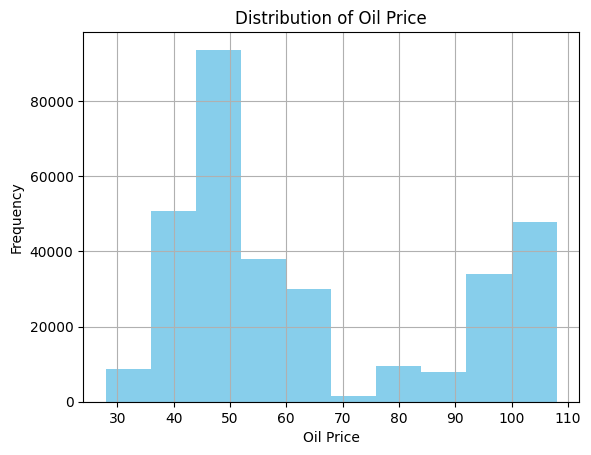

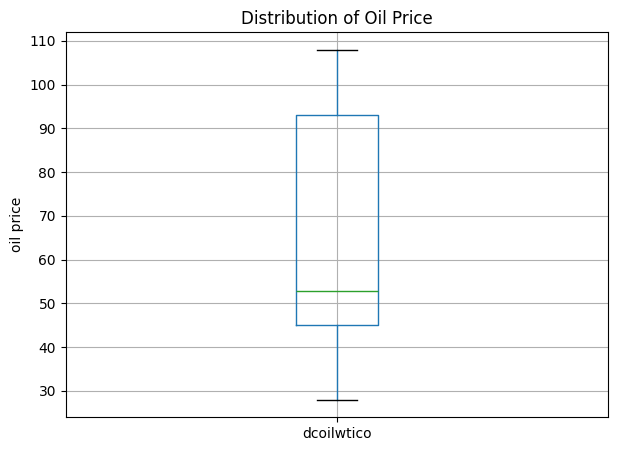

In [232]:
# Distribution of oil prices

plt.figure(figsize=(4,4))
data.hist(column=['dcoilwtico'],color='skyblue')
plt.xlabel('Oil Price')
plt.ylabel('Frequency')
plt.title('Distribution of Oil Price')
plt.show();


# Box plot
plt.figure(figsize=(7,5))
data.boxplot(column='dcoilwtico')
plt.ylabel('oil price')
plt.title('Distribution of Oil Price')
plt.show()

The histogram and boxplot of the 'dcoilwtico' variable reveal insights into its distribution. The histogram displays the frequency distribution of oil prices, indicating the number of occurrences for each price range.
The prices are not evenly distributed across a range ,there are clusters/peaks, indicating specific price levels that occur more frequently.

### Bivariate

#### Trend of Sales over time

In [233]:
# Group the data by date and calculate the total sales
daily_sales = data.groupby('date')['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()

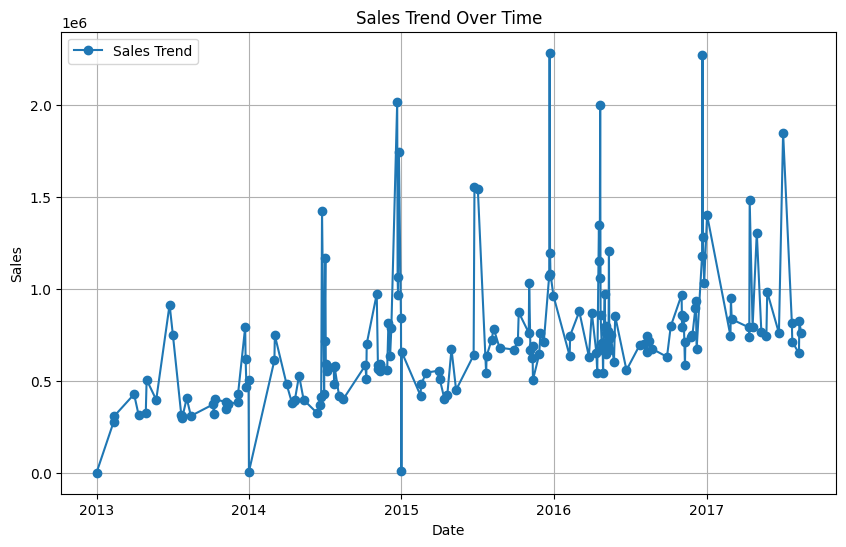

In [234]:

daily_sales = data.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(daily_sales['date'], daily_sales['sales'], label='Sales Trend', marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend Over Time')
plt.grid(True)
plt.legend()
plt.show()


The plot shows the trend of sales over time. From the graph, we can observe that the sales exhibit some variations and fluctuations over time. There are periods of both high and low sales, indicating potential seasonality or other factors affecting sales patterns.

### Trend of Crude oil Prices

In [235]:
# Visualizing the 'dcoilwtico' column to confirm if the trend is consistent.
fig = px.line(oil, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.show()

We can see that oil prices suffered a collapse towards the end of 2014 and have not recovered. In fact despite some volatility, oil prices are at the same level as they were in the beginning of 2015. As a result of this we may see a significant shift in store sales around late 2014. Looking at the unit sales data, this is not readily apparent. Although sales do appear to drop off in the early part of 2015, in late 2014 they are rising. Also, to add oil price drop doesn't seems to have any impact on the sales, as it was seen from the sales plot, there was no relation between oil price dropping on the sales, so we can say that this feature or data is of no importance to us and will not be considered during modelling.

### Multivariate

In [236]:
num_data = ['sales','transactions','onpromotion','dcoilwtico']
corr = data[num_data].corr()
corr

,sales,transactions,onpromotion,dcoilwtico
sales,1.000000,0.203691,0.418029,-0.060179
transactions,0.203691,1.000000,0.038163,-0.017346
onpromotion,0.418029,0.038163,1.000000,-0.129796
dcoilwtico,-0.060179,-0.017346,-0.129796,1.000000


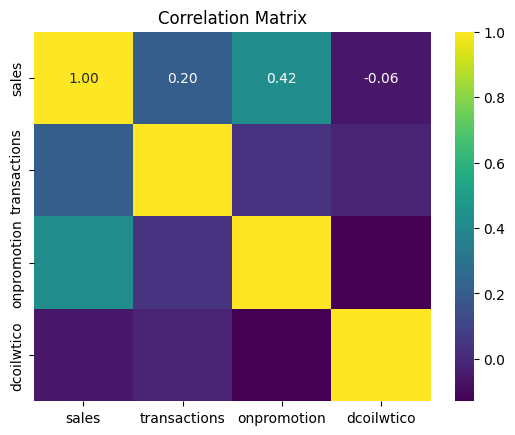

In [237]:
heatmap = sns.heatmap(data=corr,annot=True, cmap='viridis',fmt=".2f")
plt.title('Correlation Matrix')
plt.show()



- Sales and Transactions:

There is a weak positive correlation of approximately 0.200 between "Sales" and "Transactions." This suggests that there is a slight positive relationship between the number of transactions and the sales. It implies that when the number of transactions increases, there is a tendency for sales to increase as well, although the correlation is not very strong.

- Sales and Dcoilwito (Oil Prices):

There is a weak negative correlation of approximately -0.062 between "Sales" and "Dcoilwito" (Oil Prices). This indicates a slight negative relationship between sales and oil prices. It suggests that as oil prices increase, there is a tendency for sales to decrease slightly, though the correlation is not significant.

- Transactions and Dcoilwito (Oil Prices):

There is a very weak negative correlation of approximately -0.017 between "Transactions" and "Dcoilwito" (Oil Prices). This suggests that there is almost no relationship between the number of transactions and oil prices. It indicates that fluctuations in oil prices do not have a significant impact on the number of transactions.

<Figure size 600x400 with 0 Axes>

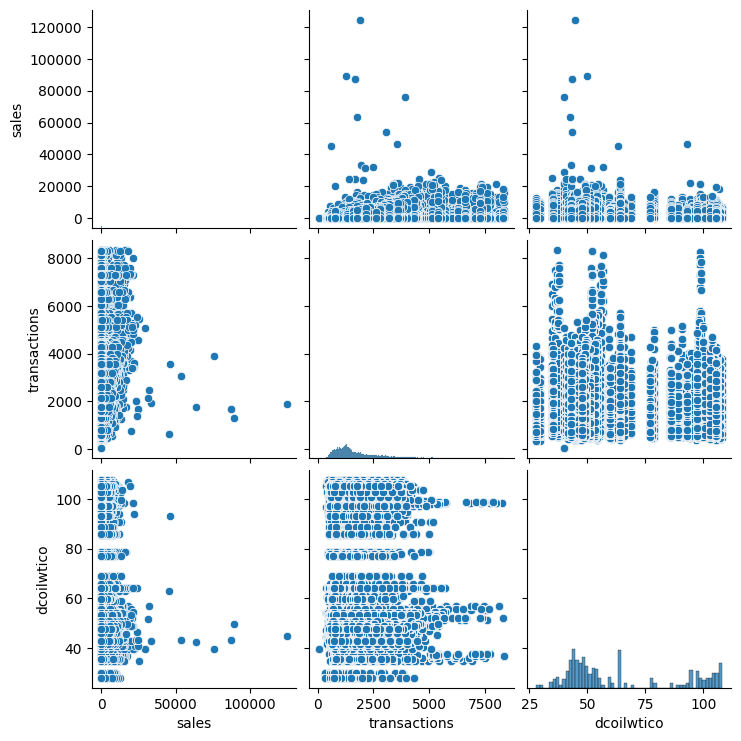

In [238]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']

# Plot scatter plot matrix
plt.figure(figsize=(6,4))
sns.pairplot(data[numerical_vars])
plt.show()

### Stationarity Test

Null Hypothesis: Series is stationary
Alternate Hypothesis: Series is not stationary

In [239]:
from statsmodels.tsa.stattools import kpss

stats, p, lags, critical_values = kpss(data['sales'])

print(f'Test statistics:{stats}')
print(f'P value: {p}')
print(f'Critical Values: {critical_values}')

if p < 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

Test statistics:20.796042221186955
P value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Series is not Stationary


## Questions

### 1)Is the train dataset complete (has all the required dates)?

In [240]:
data['date'] = pd.to_datetime(data['date'])
min_date = data['date'].min()
max_date = data['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)
 
missing_dates = expected_dates[~expected_dates.isin(data['date'])]
 
if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is incomplete. The following dates are missing:
DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05',
               '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09',
               '2013-01-10', '2013-01-11',
               ...
               '2017-08-03', '2017-08-04', '2017-08-05', '2017-08-06',
               '2017-08-07', '2017-08-08', '2017-08-09', '2017-08-12',
               '2017-08-13', '2017-08-14'],
              dtype='datetime64[ns]', length=1509, freq=None)


In [241]:
test['date'] = pd.to_datetime(test['date'])
min_date = test['date'].min()
max_date = test['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)
 
missing_dates = expected_dates[~expected_dates.isin(data['date'])]
 
if len(missing_dates) == 0:
    print("The test dataset is complete. It includes all the required dates.")
else:
    print("The test dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The test dataset is incomplete. The following dates are missing:
DatetimeIndex(['2017-08-16', '2017-08-17', '2017-08-18', '2017-08-19',
               '2017-08-20', '2017-08-21', '2017-08-22', '2017-08-23',
               '2017-08-24', '2017-08-25', '2017-08-26', '2017-08-27',
               '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31'],
              dtype='datetime64[ns]', freq='D')


### 2) Which dates have the lowest and highest sales for each year?

In [242]:
#Extract the year from the 'date' column
data['year'] = data['date'].dt.year



#Group by year and find the dates with the lowest and highest sales
data = data.dropna(subset=['year'])

# Group by year and find the dates with the lowest and highest sales
min_dates = data.loc[data.groupby('year')['sales'].idxmin(), ['year','date','sales']]
max_dates = data.loc[data.groupby('year')['sales'].idxmax(), ['year','date','sales']]

# Display the results
print("Dates with the Lowest Sales for Each Year:")
print(min_dates)

print("\nDates with the Highest Sales for Each Year:")
print(max_dates)

Dates with the Lowest Sales for Each Year:
        year       date  sales
0       2013 2013-01-01    0.0
46267   2014 2014-01-01    0.0
119791  2015 2015-01-01    0.0
185691  2016 2016-02-08    0.0
284890  2017 2017-01-02    0.0

Dates with the Highest Sales for Each Year:
        year       date     sales
36510   2013 2013-11-12   46271.0
107922  2014 2014-12-08   45361.0
166827  2015 2015-11-11   33274.0
217548  2016 2016-05-02  124717.0
286221  2017 2017-01-02   23966.0


### 3) Did the earthquake impact sales?

In [243]:
# Earthquake year 2016

# Extract the months from date column
data['month'] = data['date'].dt.month_name()


# Display the results
sales_2016 = data[data['year'] == 2016].groupby(['year', 'month'])['sales'].sum()

print('Sales for the Year 2016 are as follows:')
print(sales_2016)

Sales for the Year 2016 are as follows:
year  month    
2016  April        1.179770e+07
      August       3.502858e+06
      December     8.271371e+06
      February     1.383482e+06
      July         6.973836e+05
      June         5.596533e+05
      March        1.511977e+06
      May          1.024809e+07
      November     6.262806e+06
      October      7.976122e+05
      September    6.317612e+05
Name: sales, dtype: float64


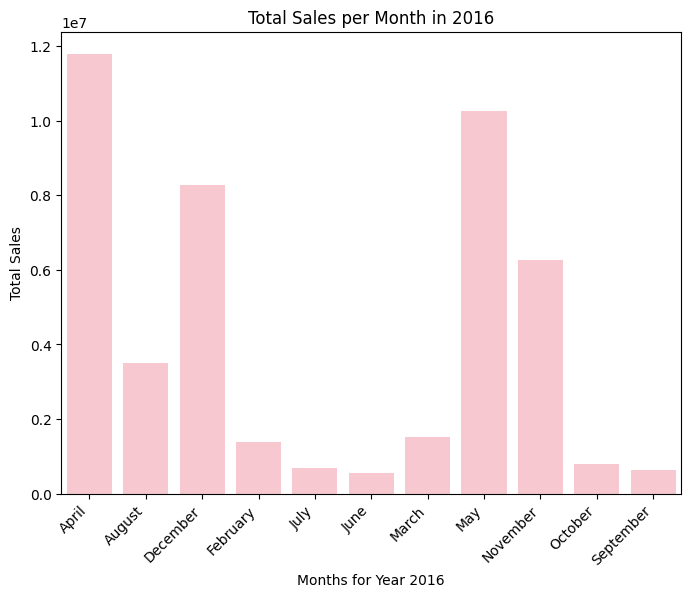

In [244]:
plt.figure(figsize=(8,6))

ax = sns.barplot(x=sales_2016.index.get_level_values('month'), y=sales_2016.values, color='pink')

# Rotate each month label individually
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right') 

plt.xlabel('Months for Year 2016')
plt.ylabel('Total Sales')
plt.title('Total Sales per Month in 2016')
plt.show()

### 4) Are certain groups of stores selling more products? (Cluster, city, state, type)

In [245]:
data.head(3)

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico,year,month
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,64.077912,2013,January
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,64.077912,2013,January
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,64.077912,2013,January


In [246]:
# Group by cluster and calculate the average sales
average_sales_by_cluster = data.groupby('cluster')['sales'].mean()

# Group by city and calculate the average sales
average_sales_by_city = data.groupby('city')['sales'].mean()

# Group by state and calculate the average sales
average_sales_by_state = data.groupby('state')['sales'].mean()

# Group by store type and calculate the average sales
average_sales_by_store_type = data.groupby('store_type')['sales'].mean()

# Set the number of bars in each plot
num_bars = len(average_sales_by_cluster)

# Generate the colors using the viridis palette
colors = plt.cm.viridis(np.linspace(0, 1, num_bars))


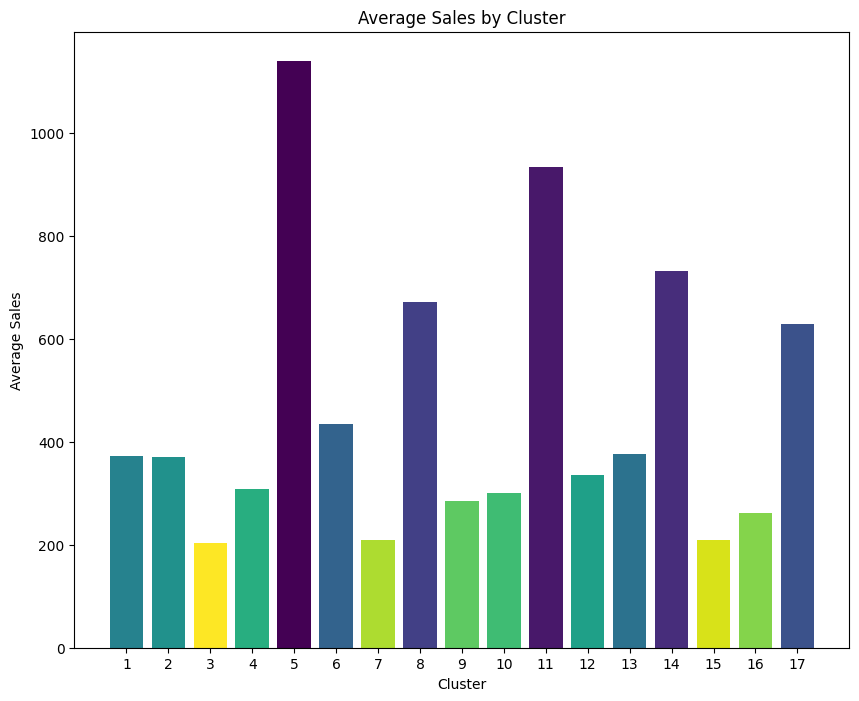

In [247]:
# Sort the data by average sales in descending order
average_sales_by_cluster = average_sales_by_cluster.sort_values(ascending=False)

# Plot the average sales by cluster
plt.figure(figsize=(10, 8))
plt.bar(average_sales_by_cluster.index, average_sales_by_cluster.values, color=colors)
plt.xlabel('Cluster')
plt.ylabel('Average Sales')
plt.title('Average Sales by Cluster')

# Set the x-tick labels as integers
plt.xticks(range(1, len(average_sales_by_cluster.index) + 1))
plt.show()

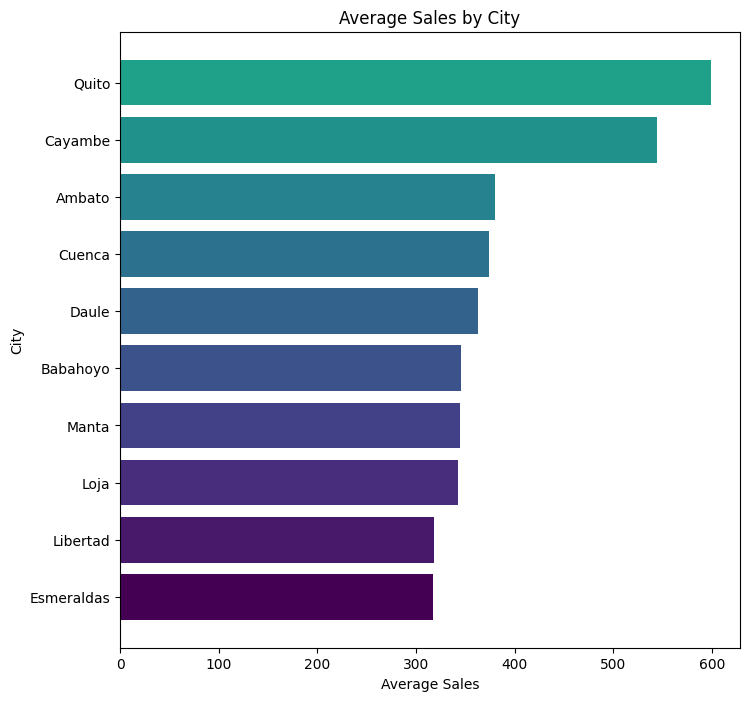

In [248]:
# Group by city and calculate the average sales
average_sales_by_city = data.groupby('city')['sales'].mean().nlargest(10)

# Sort the data by average sales in descending order
average_sales_by_city = average_sales_by_city.sort_values(ascending=True)

# Plot the average sales by city horizontally
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_city.index, average_sales_by_city.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.title('Average Sales by City')
plt.show()

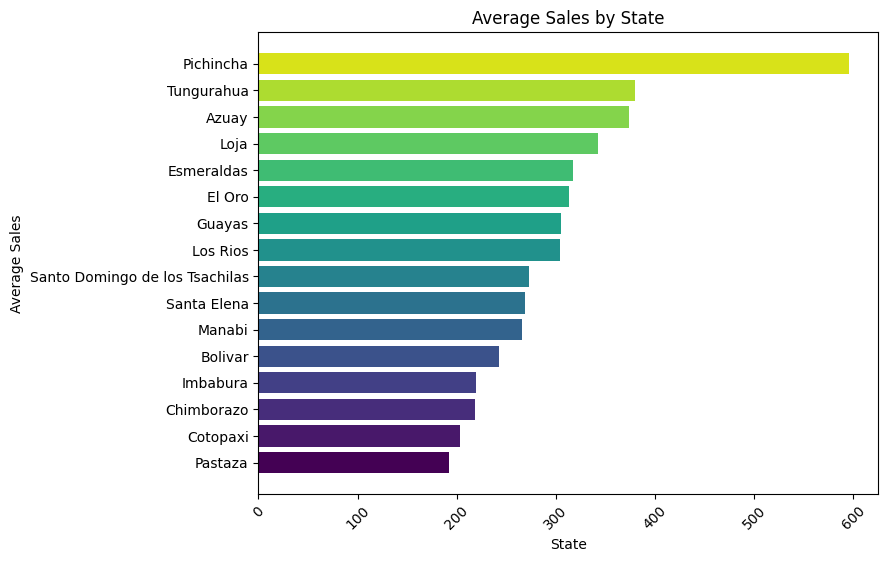

In [249]:
# Sort the data by average sales in descending order
average_sales_by_state = average_sales_by_state.sort_values(ascending=True)

# Plot the average sales by state
plt.figure(figsize=(8, 6))
plt.barh(average_sales_by_state.index, average_sales_by_state.values, color=colors)
plt.xlabel('State')
plt.ylabel('Average Sales')
plt.title('Average Sales by State')
plt.xticks(rotation=45)
plt.show()

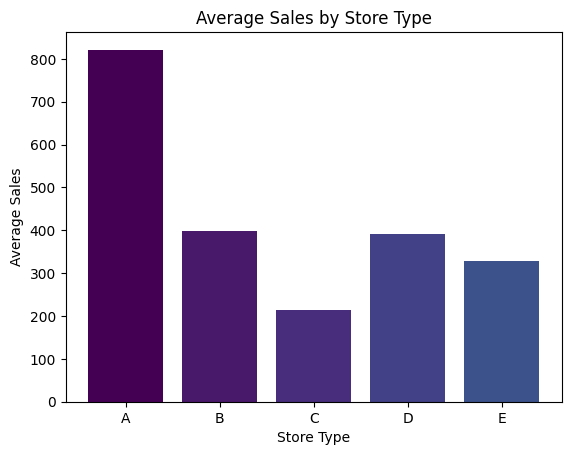

In [250]:
# Plot the average sales by store type
plt.bar(average_sales_by_store_type.index, average_sales_by_store_type.values, color=colors)
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.title('Average Sales by Store Type')
plt.show()

### 5) Are sales affected by promotions, oil prices and holidays?

In [251]:
# Calculate correlations between sales and promotions, oil prices, holidays
corr_sales_promotions = data['sales'].corr(data['onpromotion'])
corr_sales_oil = data['sales'].corr(data['dcoilwtico'])
corr_sales_holidays = data['sales'].corr(data['holiday_type'] == 'Holiday')

# Print the correlation values
print(f"Correlation between Sales and Promotions: {corr_sales_promotions}")
print(f"Correlation between Sales and Oil Prices: {corr_sales_oil}")
print(f"Correlation between Sales and Holidays: {corr_sales_holidays}")

Correlation between Sales and Promotions: 0.4180289197242383
Correlation between Sales and Oil Prices: -0.06017923445121323
Correlation between Sales and Holidays: -0.03706892930251701


- Promotions:
There is a positive correlation of approximately 0.42 between sales and promotions. This suggests that promotions have a moderate positive impact on sales. When promotions are running, there is an increased likelihood of higher sales.


- Oil Prices:
There is a weak negative correlation of approximately -0.06 between sales and oil prices. This indicates that there is a slight negative relationship between sales and oil prices. However, the correlation is close to zero, suggesting that oil prices have minimal impact on sales.


- Holidays:
There is a very weak negative correlation of approximately -0.04 between sales and holidays. This indicates that there is almost no relationship between sales and holidays. Holidays do not seem to have a significant impact on sales.
These insights suggest that promotions have a relatively stronger influence on sales compared to oil prices and holidays. While promotions positively impact sales, oil prices and holidays show minimal or no relationship with sales.

# FEATURE ENGINEERING

### Train Dataset

In [252]:
data.head(3)

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico,year,month
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,64.077912,2013,January
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,64.077912,2013,January
2,563,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,64.077912,2013,January


In [253]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   city          322047 non-null  object        
 7   state         322047 non-null  object        
 8   store_type    322047 non-null  object        
 9   cluster       322047 non-null  int64         
 10  transactions  322047 non-null  int64         
 11  holiday_type  322047 non-null  object        
 12  locale        322047 non-null  object        
 13  locale_name   322047 non-null  object        
 14  description   322047 non-null  object        
 15  transferred   322

In [254]:
# To extract the days from the date column

data['day'] = data['date'].dt.day
data['Month'] = data['date'].dt.month
data['month_name'] = data['date'].dt.month_name()

data.drop(columns='month',inplace=True)

In [255]:
data.head(2)

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,holiday_type,locale,locale_name,description,transferred,dcoilwtico,year,day,Month,month_name
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,...,Holiday,National,Ecuador,Primer dia del ano,False,64.077912,2013,1,1,January
1,562,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,...,Holiday,National,Ecuador,Primer dia del ano,False,64.077912,2013,1,1,January


#### Dropping unnecessary columns

In [256]:
data = data.drop(columns=['id','date','store_nbr','cluster','locale','locale_name','description','transferred','month_name'])

data.head()

,family,sales,onpromotion,city,state,store_type,transactions,holiday_type,dcoilwtico,year,day,Month
0,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,770,Holiday,64.077912,2013,1,1
1,BABY CARE,0.0,0,Salinas,Santa Elena,D,770,Holiday,64.077912,2013,1,1
2,BEAUTY,2.0,0,Salinas,Santa Elena,D,770,Holiday,64.077912,2013,1,1
3,BEVERAGES,810.0,0,Salinas,Santa Elena,D,770,Holiday,64.077912,2013,1,1
4,BOOKS,0.0,0,Salinas,Santa Elena,D,770,Holiday,64.077912,2013,1,1


### Product Categorization Based on Families

In [257]:
data['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

#### Cleaning of family column

In [258]:
food_family = ['BREAD/BAKERY','FROZEN FOODS', 'GROCERY I', 'GROCERY II','PREPARED FOODS','POULTRY','DAIRY', 'DELI', 'MEATS','EGGS','SEAFOOD','PRODUCE']
clothing_family = ['LADIESWEAR','LINGERIE']
home_family = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES','LAWN AND GARDEN']
beauty_family = ['BABY CARE', 'BEAUTY','PERSONAL CARE']
cleaning_family = ['CLEANING','HOME CARE']
stationery_family = ['SCHOOL AND OFFICE SUPPLIES','BOOKS','MAGAZINES']
beverage_family = ['LIQUOR','WINE','BEER','BEVERAGES']
hardware_family = ['PLAYERS AND ELECTRONICS','HARDWARE']
pet_family = ['PET SUPPLIES']
celebration_family = ['CELEBRATION']


# Categorize the 'family' column based on the product categories
data['family'] = np.where(data['family'].isin(food_family), 'FOODS', data['family'])
data['family'] = np.where(data['family'].isin(home_family), 'HOME', data['family'])
data['family'] = np.where(data['family'].isin(clothing_family), 'CLOTHING', data['family'])
data['family'] = np.where(data['family'].isin(beauty_family), 'BEAUTY', data['family'])
data['family'] = np.where(data['family'].isin(stationery_family), 'STATIONERY', data['family'])
data['family'] = np.where(data['family'].isin(cleaning_family), 'CLEANING', data['family'])
data['family'] = np.where(data['family'].isin(hardware_family), 'HARDWARE', data['family'])
data['family'] = np.where(data['family'].isin(beverage_family), 'BEVERAGE', data['family'])
data['family'] = np.where(data['family'].isin(pet_family), 'PET', data['family'])
data['family'] = np.where(data['family'].isin(celebration_family), 'CELEBRATION', data['family'])

data.head()



,family,sales,onpromotion,city,state,store_type,transactions,holiday_type,dcoilwtico,year,day,Month
0,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,770,Holiday,64.077912,2013,1,1
1,BEAUTY,0.0,0,Salinas,Santa Elena,D,770,Holiday,64.077912,2013,1,1
2,BEAUTY,2.0,0,Salinas,Santa Elena,D,770,Holiday,64.077912,2013,1,1
3,BEVERAGE,810.0,0,Salinas,Santa Elena,D,770,Holiday,64.077912,2013,1,1
4,STATIONERY,0.0,0,Salinas,Santa Elena,D,770,Holiday,64.077912,2013,1,1


### Split Data into X,y

In [259]:
X = data.drop(columns=['sales'], axis=1)
y = data['sales']

X.head()


,family,onpromotion,city,state,store_type,transactions,holiday_type,dcoilwtico,year,day,Month
0,AUTOMOTIVE,0,Salinas,Santa Elena,D,770,Holiday,64.077912,2013,1,1
1,BEAUTY,0,Salinas,Santa Elena,D,770,Holiday,64.077912,2013,1,1
2,BEAUTY,0,Salinas,Santa Elena,D,770,Holiday,64.077912,2013,1,1
3,BEVERAGE,0,Salinas,Santa Elena,D,770,Holiday,64.077912,2013,1,1
4,STATIONERY,0,Salinas,Santa Elena,D,770,Holiday,64.077912,2013,1,1


In [260]:
y.head()

0      0.0
1      0.0
2      2.0
3    810.0
4      0.0
Name: sales, dtype: float64

## Encode Categorical Data

In [261]:
categorical_columns = X.select_dtypes("object").columns
categorical_columns

Index(['family', 'city', 'state', 'store_type', 'holiday_type'], dtype='object')

In [262]:
numerical_columns = X.select_dtypes('number').columns
numerical_columns

Index(['onpromotion', 'transactions', 'dcoilwtico', 'year', 'day', 'Month'], dtype='object')

In [263]:
# Encode independent variable using the onehotencoder

from sklearn.preprocessing import OneHotEncoder
# Encode using OneHotEncoder
encoder = OneHotEncoder()
encoded = encoder.fit_transform(data[categorical_columns])

# To print the column names
column_names = encoder.get_feature_names_out(categorical_columns)

# Convert the encoded data to a df
data_encoded = pd.DataFrame(encoded.toarray(), columns=column_names)

#Concate the Original Dataframe with the encoded one
data_encoded = pd.concat([data_encoded, data], axis=1)

#Drop the original Categorical columns
data_encoded.drop(categorical_columns,axis=1, inplace=True)

#Print the encoded df
data_encoded.head()



,family_AUTOMOTIVE,family_BEAUTY,family_BEVERAGE,family_CELEBRATION,family_CLEANING,family_CLOTHING,family_FOODS,family_HARDWARE,family_HOME,"family_LIQUOR,WINE,BEER",...,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer,sales,onpromotion,transactions,dcoilwtico,year,day,Month
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0,770,64.077912,2013,1,1
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0,770,64.077912,2013,1,1
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,2.0,0,770,64.077912,2013,1,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,810.0,0,770,64.077912,2013,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0,770,64.077912,2013,1,1


In [264]:
data_encoded.shape

(322047, 67)

In [265]:
data_encoded.columns

Index(['family_AUTOMOTIVE', 'family_BEAUTY', 'family_BEVERAGE',
       'family_CELEBRATION', 'family_CLEANING', 'family_CLOTHING',
       'family_FOODS', 'family_HARDWARE', 'family_HOME',
       'family_LIQUOR,WINE,BEER', 'family_PET', 'family_STATIONERY',
       'city_Ambato', 'city_Babahoyo', 'city_Cayambe', 'city_Cuenca',
       'city_Daule', 'city_El Carmen', 'city_Esmeraldas', 'city_Guaranda',
       'city_Guayaquil', 'city_Ibarra', 'city_Latacunga', 'city_Libertad',
       'city_Loja', 'city_Machala', 'city_Manta', 'city_Playas', 'city_Puyo',
       'city_Quevedo', 'city_Quito', 'city_Riobamba', 'city_Salinas',
       'city_Santo Domingo', 'state_Azuay', 'state_Bolivar',
       'state_Chimborazo', 'state_Cotopaxi', 'state_El Oro',
       'state_Esmeraldas', 'state_Guayas', 'state_Imbabura', 'state_Loja',
       'state_Los Rios', 'state_Manabi', 'state_Pastaza', 'state_Pichincha',
       'state_Santa Elena', 'state_Santo Domingo de los Tsachilas',
       'state_Tungurahua', 'store

### TEST DF

In [266]:
# Extracting Date Components
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test.head()

,id,date,store_nbr,family,onpromotion,year,month,day
0,3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16
1,3000889,2017-08-16,1,BABY CARE,0,2017,8,16
2,3000890,2017-08-16,1,BEAUTY,2,2017,8,16
3,3000891,2017-08-16,1,BEVERAGES,20,2017,8,16
4,3000892,2017-08-16,1,BOOKS,0,2017,8,16


In [267]:
# Dropping Unnecessary Columns
columns_to_drop = ['date', 'id','store_nbr']
test = test.drop(columns=columns_to_drop)
test.head()

,family,onpromotion,year,month,day
0,AUTOMOTIVE,0,2017,8,16
1,BABY CARE,0,2017,8,16
2,BEAUTY,2,2017,8,16
3,BEVERAGES,20,2017,8,16
4,BOOKS,0,2017,8,16


In [268]:
food_family = ['BREAD/BAKERY','FROZEN FOODS', 'GROCERY I', 'GROCERY II','PREPARED FOODS','POULTRY','DAIRY', 'DELI', 'MEATS','EGGS','SEAFOOD','PRODUCE']
clothing_family = ['LADIESWEAR','LINGERIE']
home_family = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES','LAWN AND GARDEN']
beauty_family = ['BABY CARE', 'BEAUTY','PERSONAL CARE']
cleaning_family = ['CLEANING','HOME CARE']
stationery_family = ['SCHOOL AND OFFICE SUPPLIES','BOOKS','MAGAZINES']
beverage_family = ['LIQUOR','WINE','BEER','BEVERAGES']
hardware_family = ['PLAYERS AND ELECTRONICS','HARDWARE']
pet_family = ['PET SUPPLIES']
celebration_family = ['CELEBRATION']


# Categorize the 'family' column based on the product categories
test['family'] = np.where(test['family'].isin(food_family), 'FOODS', test['family'])
test['family'] = np.where(test['family'].isin(home_family), 'HOME', test['family'])
test['family'] = np.where(test['family'].isin(clothing_family), 'CLOTHING', test['family'])
test['family'] = np.where(test['family'].isin(beauty_family), 'BEAUTY', test['family'])
test['family'] = np.where(test['family'].isin(stationery_family), 'STATIONERY', test['family'])
test['family'] = np.where(test['family'].isin(cleaning_family), 'CLEANING', test['family'])
test['family'] = np.where(test['family'].isin(hardware_family), 'HARDWARE', test['family'])
test['family'] = np.where(test['family'].isin(beverage_family), 'BEVERAGE', test['family'])
test['family'] = np.where(test['family'].isin(pet_family), 'PET', test['family'])
test['family'] = np.where(test['family'].isin(celebration_family), 'CELEBRATION', test['family'])

test.head()


,family,onpromotion,year,month,day
0,AUTOMOTIVE,0,2017,8,16
1,BEAUTY,0,2017,8,16
2,BEAUTY,2,2017,8,16
3,BEVERAGE,20,2017,8,16
4,STATIONERY,0,2017,8,16


In [269]:
test_categorical = test.select_dtypes('object').columns

test_categorical =['family']

In [270]:

# Encode using OneHotEncoder
encoder = OneHotEncoder()

encoded = encoder.fit_transform(test[test_categorical])

# To print the column names
column_names = encoder.get_feature_names_out(test_categorical)

# Convert the encoded data to a df
test_encoded = pd.DataFrame(encoded.toarray(), columns=column_names)

#Concate the Original Dataframe with the encoded one
test_encoded = pd.concat([test_encoded, test], axis=1)

#Drop the original Categorical columns
test_encoded.drop(test_categorical,axis=1, inplace=True)

#Print the encoded df
test_encoded.head()


,family_AUTOMOTIVE,family_BEAUTY,family_BEVERAGE,family_CELEBRATION,family_CLEANING,family_CLOTHING,family_FOODS,family_HARDWARE,family_HOME,"family_LIQUOR,WINE,BEER",family_PET,family_STATIONERY,onpromotion,year,month,day
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2017,8,16
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2017,8,16
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2017,8,16
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,2017,8,16
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,2017,8,16


In [271]:
test_encoded.shape

(28512, 16)

## MoDELING

### Split Data Into Train and Test

In [272]:
from sklearn.model_selection import train_test_split


train_set = data_encoded.loc[data_encoded['year'].isin([2013, 2014, 2015, 2016])]
test_set = data_encoded.loc[data_encoded['year'] == 2017]

In [273]:
train_set.shape

(284889, 67)

In [274]:
test_set.shape

(37158, 67)

In [275]:
X_train = train_set.drop('sales',axis = 1)
y_train = train_set['sales']

X_test = test_set.drop('sales', axis=1)
y_test = test_set['sales']

In [276]:
X_train

,family_AUTOMOTIVE,family_BEAUTY,family_BEVERAGE,family_CELEBRATION,family_CLEANING,family_CLOTHING,family_FOODS,family_HARDWARE,family_HOME,"family_LIQUOR,WINE,BEER",...,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer,onpromotion,transactions,dcoilwtico,year,day,Month
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0,770,64.077912,2013,1,1
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0,770,64.077912,2013,1,1
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0,770,64.077912,2013,1,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0,770,64.077912,2013,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0,770,64.077912,2013,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284884,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,2712,64.077912,2016,26,12
284885,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2,2712,64.077912,2016,26,12
284886,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3,2712,64.077912,2016,26,12
284887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,2712,64.077912,2016,26,12


#### Feature Scaling

In [277]:
from sklearn.preprocessing import StandardScaler, RobustScaler
sc =StandardScaler()

X_numerical_cols = ['onpromotion','transactions','dcoilwtico']

X_train[X_numerical_cols] = sc.fit_transform(X_train[X_numerical_cols])
X_test[X_numerical_cols] = sc.transform(X_test[X_numerical_cols])

In [278]:
X_train

,family_AUTOMOTIVE,family_BEAUTY,family_BEVERAGE,family_CELEBRATION,family_CLEANING,family_CLOTHING,family_FOODS,family_HARDWARE,family_HOME,"family_LIQUOR,WINE,BEER",...,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer,onpromotion,transactions,dcoilwtico,year,day,Month
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.214943,-0.916848,-0.056426,2013,1,1
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.214943,-0.916848,-0.056426,2013,1,1
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.214943,-0.916848,-0.056426,2013,1,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.214943,-0.916848,-0.056426,2013,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.214943,-0.916848,-0.056426,2013,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284884,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.214943,0.911770,-0.056426,2016,26,12
284885,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.081666,0.911770,-0.056426,2016,26,12
284886,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.015028,0.911770,-0.056426,2016,26,12
284887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.214943,0.911770,-0.056426,2016,26,12


In [279]:
X_test

,family_AUTOMOTIVE,family_BEAUTY,family_BEVERAGE,family_CELEBRATION,family_CLEANING,family_CLOTHING,family_FOODS,family_HARDWARE,family_HOME,"family_LIQUOR,WINE,BEER",...,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer,onpromotion,transactions,dcoilwtico,year,day,Month
284889,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-0.214943,-1.156018,-0.056426,2017,2,1
284890,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-0.214943,-1.156018,-0.056426,2017,2,1
284891,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-0.214943,-1.156018,-0.056426,2017,2,1
284892,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.850849,-1.156018,-0.056426,2017,2,1
284893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,-0.214943,-1.156018,-0.056426,2017,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322042,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.214943,0.387290,-0.707712,2017,15,8
322043,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,-0.148304,0.387290,-0.707712,2017,15,8
322044,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,9.647546,0.387290,-0.707712,2017,15,8
322045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.318165,0.387290,-0.707712,2017,15,8


Feature scaling is a preprocessing technique used to standardize or normalize the range of independent variables or features of a dataset. The goal of feature scaling is to bring all features to a similar scale, preventing some features from dominating others during the modeling process. This is particularly important for algorithms that are sensitive to the scale of input features.

Scaling features makes ensuring that each characteristic is given the same consideration during the learning process which also guarantees that each feature contributes fairly to model predictions.


In [280]:
# Initialize the results dataframe
results_df = pd.DataFrame(columns=['Model','MSE','MAE','RMSE', 'RMSLE',])

### TRAIN MODELS

### 1. Linear Regression Model

In [281]:
linear_Reg = LinearRegression()
model_linear = linear_Reg.fit(X_train,y_train)
#make prediction on X test
lr_predict = model_linear.predict(X_test)

# Calculate metrics
# Calculate Mean Squared Error (MSE)
lr_mse = mean_squared_error(y_test,lr_predict).round(2)

# Calculate Mean Absolute Error (MAE)
lr_mae = mean_absolute_error(y_test,lr_predict).round(2)

# Apply the absolute value function to both y_eval and lr_predictions
y_test_abs = abs(y_test)
lr_predict_abs = abs(lr_predict)

# Calculate the root Mean Squared error
lr_rmse = np.sqrt(mean_squared_error(y_test_abs,lr_predict_abs)).round(2)

# Calculate the log Root Mean Squared Logarithmic Error (RMSLE)
lr_rmsle = np.sqrt(mean_squared_log_error(y_test_abs,lr_predict_abs)).round(2)

# Create a DataFrame to store results for Linear Regression
lr_results = pd.DataFrame({'Model': ['Linear Regression'],
                           'MSE'  : [lr_mse],
                           'MAE'  : [lr_mae],
                           'RMSE' : [lr_rmse],
                           'RMSLE': [lr_rmsle]
                         })

lr_results

,Model,MSE,MAE,RMSE,RMSLE
0,Linear Regression,991653.06,436.56,995.13,2.79


### Model 2. ARIMA (AutoRegressive Integrated Moving Average)

In [282]:
# ARIMA Model
# d and q are equal to zero as data is already stationary
p = 1
d = 0 
q = 0  

# Create an instance of the ARIMA model
arima_model = ARIMA(y_train, order=(p, d, q))

# Fit the model to the training data
arima_model_fit = arima_model.fit()

# Make predictions on the evaluation data
arima_predictions = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(X_test) - 1)

# Calculate evaluation metrics
arima_mse = mean_squared_error(y_test, arima_predictions)
arima_rmse = np.sqrt(arima_mse)

# Apply the absolute value function to y_eval to remove negative signs
y_eval_abs = abs(y_test)
arima_predictions_abs = abs(arima_predictions)

# Calculate the Mean Absolute Error (MAE)
arima_mae = mean_absolute_error(y_test, arima_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
arima_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, arima_predictions_abs))

# Create a DataFrame to store results for ARIMA
results_arima = pd.DataFrame({'Model': ['ARIMA'],
                              'MSE': [arima_mse],
                              'MAE': [arima_mae],
                              'RMSLE': [arima_rmsle],
                              'RMSE': [np.sqrt(arima_mse)]
                            }).round(2)

# Print the results_arima dataframe
results_arima

,Model,MSE,MAE,RMSLE,RMSE
0,ARIMA,1845156.98,618.57,3.44,1358.37


### Model 3. Random Forest Regression

In [283]:
rf_regression = RandomForestRegressor(n_estimators=1000, random_state=42)
model_rf = linear_Reg.fit(X_train,y_train)
#make prediction on X test
rf_predict = model_rf.predict(X_test)

# Calculate metrics
# Calculate Mean Squared Error (MSE)
rf_mse = mean_squared_error(y_test,rf_predict).round(2)

# Calculate Mean Absolute Error (MAE)
rf_mae = mean_absolute_error(y_test,lr_predict).round(2)

# Apply the absolute value function to both y_eval and lr_predictions
y_test_abs = abs(y_test)
rf_predict_abs = abs(rf_predict)

# Calculate the root Mean Squared error
rf_rmse = np.sqrt(mean_squared_error(y_test_abs,rf_predict_abs)).round(2)

# Calculate the log Root Mean Squared Logarithmic Error (RMSLE)
rf_rmsle = np.sqrt(mean_squared_log_error(y_test_abs,rf_predict_abs)).round(2)

# Create a DataFrame to store results for Linear Regression
rf_results = pd.DataFrame({'Model': ['Random Forest'],
                           'MSE'  : [rf_mse],
                           'MAE'  : [rf_mae],
                           'RMSE' : [rf_rmse],
                           'RMSLE': [rf_rmsle]
                         })

rf_results

,Model,MSE,MAE,RMSE,RMSLE
0,Random Forest,991653.06,436.56,995.13,2.79


- RMSLE (Root Mean Squared Logarithmic Error):
        Definition: RMSLE is a metric that measures the ratio between the logarithm of the predicted and actual values. It is particularly useful when the target variable has a wide range of values.
        Interpretation: A lower RMSLE indicates better model performance. It penalizes underestimation and overestimation equally. RMSLE is often preferred when the target variable has a skewed distribution.

- RMSE (Root Mean Squared Error):
        Definition: RMSE is a standard metric that measures the average magnitude of the errors between predicted and actual values. It is the square root of the mean squared differences.
        Interpretation: Like RMSLE, a lower RMSE signifies better performance. It penalizes larger errors more heavily than smaller errors. RMSE is sensitive to outliers and tends to be influenced by large errors.

- MSE (Mean Squared Error):
        Definition: MSE is the mean of the squared differences between predicted and actual values. It measures the average squared deviation of predictions from the true values.
        Interpretation: Similar to RMSE, lower MSE values are indicative of better model performance. MSE has the advantage of being in the same unit as the squared target variable, making it easy to interpret.

- MAE (Mean Absolute Error):
        Definition: MAE is the mean of the absolute differences between predicted and actual values. It measures the average magnitude of errors without considering their direction.
        Interpretation: Lower MAE values indicate better model performance. MAE is less sensitive to outliers compared to RMSE, making it a robust metric. It is often preferred when outliers are present and their impact should be minimized.

These results indicate the performance of each model in terms of different metrics. Lower values of RMSLE, RMSE, MSE, and MAE indicate better model performance. Based on these results, the Random Forest appear to perform better than the Linear Regression, ARIMA models in terms of the provided metrics.

### Hyperparameter Tuning

In [284]:
model = RandomForestRegressor(random_state=42)

In [285]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_split': min_samples_split}
# print(random_grid)
# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter =20, cv = 3, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(X_train, y_train)

Hyperparameter tuning (or hyperparameter optimization) is the process of determining the right combination of hyperparameters that maximizes the model performance. It works by running multiple trials in a single training process. Each trial is a complete execution of your training application with values for your chosen hyperparameters, set within the limits you specify. This process once finished will give you the set of hyperparameter values that are best suited for the model to give optimal results.

In [ ]:
with open("rf_random.pkl", 'rb') as file:
    loaded_model = pickle.load(file)

### Evaluate model with Test Data

In [ ]:


new_data = pd.read_csv('test.csv')

if hasattr(loaded_model):
    # Apply the same preprocessing steps
    new_data_preprocessed = loaded_model.transform(new_data)
else:
    # No preprocessing step in the pipeline
    new_data_preprocessed = new_data

# Make predictions using the loaded logistic regression 
y_pred_proba = loaded_model.predict_proba(new_data_preprocessed)[:, 1]